In [108]:
#cały zbiór
#inny podział - nie jest po równo w klasach, ale jest taki sam rozkład train/test (stratified) jak w całym zbiorze

### Import bibliotek

In [119]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
#from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Zbiór danych

Pochodzi z platformy Kaggle: https://www.kaggle.com/datasets/datasnaek/mbti-type .

In [120]:
#każdy rząd składa się z typu osobowości i 50 ostatnich postów
df = pd.read_csv('mbti_1.csv', sep=',')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [121]:
df.shape

(8675, 2)

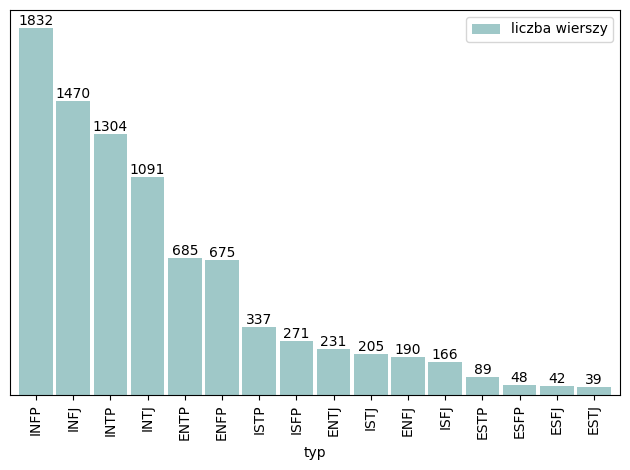

In [122]:
#podstawowy zbiór danych - dystrybucja postów między typami
#https://www.simplifiedsciencepublishing.com/resources/best-color-palettes-for-scientific-figures-and-data-visualizations

ax = df.groupby('type').count().sort_values(by='posts', ascending=False).plot.bar(width=0.9, color='#9fc8c8')
ax.bar_label(ax.containers[0])[1]
ax.legend(["liczba wierszy"])
ax.set_xlabel("typ")
ax.yaxis.set_visible(False)
ax.figure.tight_layout()
ax.figure.savefig('distribution.png')

In [123]:
#16 typów osobowości - nazwy klas
types = df.type.unique().tolist()
print(types)

#dodanie kolumny z klasami wyrażonymi liczbami (0 - 15)
df['class_no'] = df.apply(lambda x: types.index(x['type']), axis=1)

df

['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP', 'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']


,type,posts,class_no
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,2
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",3
4,ENTJ,'You're fired.|||That's another silly misconce...,4
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,8
8671,ENFP,'So...if this thread already exists someplace ...,7
8672,INTP,'So many questions when i do these things. I ...,2
8673,INFP,'I am very conflicted right now when it comes ...,6


In [124]:
#słownik odkodowujący
idx_to_type = {}
for i, t in enumerate(types): idx_to_type[i] = t

idx_to_type

{0: 'INFJ',
 1: 'ENTP',
 2: 'INTP',
 3: 'INTJ',
 4: 'ENTJ',
 5: 'ENFJ',
 6: 'INFP',
 7: 'ENFP',
 8: 'ISFP',
 9: 'ISTP',
 10: 'ISFJ',
 11: 'ISTJ',
 12: 'ESTP',
 13: 'ESFP',
 14: 'ESTJ',
 15: 'ESFJ'}

In [125]:
#zamiana separatora postów na inny, łatwo rozróżnialny
df['posts_list'] = df['posts'].str.replace(pat = '|||', repl = ' ||| ')

#zamiana stringów na listy postów
df['posts_list'] = df['posts_list'].str.split(pat = ' ||| ', regex=False)

In [126]:
#POMINIETO
# #dodanie kolumny z długościami list
# df['len_posts'] = df['posts_list'].str.len()

In [127]:
#POMINIĘTO
# #dodanie kolumny z długościami list
# df['len_posts'] = df['posts_list'].str.len()

# #niektóre rzędy posiadają mniej niż 50 postów
# df[df.len_posts < 50].shape

In [128]:
#POMINIĘTO
# #usuwamy rzędy zawierające mniej niż 50 postów
# df = df[df.len_posts == 50]

# #usuwanie kolumny z ilościami postów
# df = df.drop(columns = ['len_posts'])

In [129]:
df[['type', 'posts']].groupby('type').count().sort_values(by='posts', ascending=False)#.plot.bar(width=0.9)
# ax.bar_label(ax.containers[0])[1]
# ax.yaxis.set_visible(False)

,posts
type,
INFP,1832
INFJ,1470
INTP,1304
INTJ,1091
ENTP,685
ENFP,675
ISTP,337
ISFP,271
ENTJ,231


### Podział danych

Ważne, aby posty jednej osoby nie znalazły się zarówno w zbiorze testowym jak i treningowym. W zbiorze testowym znajdzie się 20% wierszy każdego typu.

In [ ]:
# random.seed(10)

# df_test = pd.DataFrame()
# df_train = pd.DataFrame()

# for t in types:
#     df_type = df[df.type == t]

#     test_indexes = random.sample(df_type.index.to_list(), 10)
#     df_type_test = df_type.loc[test_indexes]
#     df_type_train = df_type[~df_type.index.isin(test_indexes)]

#     df_test = pd.concat([df_test, df_type_test])
#     df_train = pd.concat([df_train, df_type_train])

# df_test.shape, df_train.shape

((160, 4), (8515, 4))

In [131]:
from sklearn.model_selection import train_test_split

# Stratify split 80/20
df_train, df_test = train_test_split(df, test_size=0.2,random_state=42,stratify=df.type)

In [132]:
tab = df.loc[:, ['type', 'posts']].groupby('type').count()
tab2 = df_train.loc[:, ['type', 'posts']].groupby("type").count()
tab3 = df_test.loc[:, ['type', 'posts']].groupby("type").count()

tab.join(tab2, rsuffix="_train").join(tab3, rsuffix="_test")  #stratified split review

,posts,posts_train,posts_test
type,,,
ENFJ,190,152,38
ENFP,675,540,135
ENTJ,231,185,46
ENTP,685,548,137
ESFJ,42,33,9
ESFP,48,38,10
ESTJ,39,31,8
ESTP,89,71,18
INFJ,1470,1176,294


### Rozpakowanie postów

Każdy z wierszy zawiera wewnątrz 50 postów. Należy traktować je oddzielnie.

In [133]:
#rozpakowanie list do osobnych rzędów
df_test = df_test.explode('posts_list')
df_train = df_train.explode('posts_list')

df_test.shape, df_train.shape

((84506, 4), (338339, 4))

In [134]:
#usunięcie zbiorczej kolumny
df_test = df_test.drop(columns = ['posts'])
df_train = df_train.drop(columns = ['posts'])

#zmiana nazwy kolumny
df_test = df_test.rename(columns = {'posts_list':'post'})
df_train = df_train.rename(columns = {'posts_list':'post'})

In [135]:
df_test.dtypes

type        object
class_no     int64
post        object
dtype: object

In [136]:
#zmiana typów zmiennych
df_test = df_test.astype({'type':'string', 'post':'string'})
df_train = df_train.astype({'type':'string', 'post':'string'})

In [137]:
df_test.shape, df_train.shape

((84506, 3), (338339, 3))

In [138]:
df_test.head()

,type,class_no,post
7814,INFP,6,"'Macona , it depends if the big family has ext..."
7814,INFP,6,^ not to break the infp erotica theme going he...
7814,INFP,6,exactly me! though i tend to turn to god a lot...
7814,INFP,6,"woah, so are mine! my dad's the ISTJ and my mo..."
7814,INFP,6,i've been m.i.a from this site for a couple of...


### Czyszczenie tekstu i ekstrakcja cech

Tokenizacja

In [139]:
#zmiejszenie liter i rozdzielenie ciągów znaków na listy słów/cząstek
# df_test['post_words'] = df_test.apply(lambda x: word_tokenize(x['post'].lower()), axis=1)
# df_train['post_words'] = df_train.apply(lambda x: word_tokenize(x['post'].lower()), axis=1)

#zmiejszenie liter i rozdzielenie ciągów znaków na listy słów/cząstek - ten tokenizer nie rozdziela na "he" + "'s" i zachowuje całe emotki oraz hashtagi
tweet_tokenizer = TweetTokenizer()
df_test['post_words'] = df_test.apply(lambda x: tweet_tokenizer.tokenize(x['post'].lower()), axis=1)
df_train['post_words'] = df_train.apply(lambda x: tweet_tokenizer.tokenize(x['post'].lower()), axis=1)

In [140]:
print(df_test.index) #problem powtarzalnych indeksów

#naprawa - unikalne indeksy
df_test = df_test.reset_index()
df_train = df_train.reset_index()

print(df_test.index)

Index([7814, 7814, 7814, 7814, 7814, 7814, 7814, 7814, 7814, 7814,
       ...
       5458, 5458, 5458, 5458, 5458, 5458, 5458, 5458, 5458, 5458],
      dtype='int64', length=84506)
RangeIndex(start=0, stop=84506, step=1)


Słowa bez znaczenia

In [141]:
#usuwanie słów bez znaczenia ('stopwords')
nltk.download('stopwords')

#wszystkie są pisane małymi literami
#uwaga - usunięte będą zarówno słowa "have/has" jak i skrócone wersje "i've/he's" - jeśli typy osobowości znajdują rozróżnienie na tym polu to badanie będzie ograniczone
stopwords.words('english')[:15], stopwords.words('english')[-15:]

#co istotne - zbiór zawiera zarówno wersje słów "w całości" jak i "w częściach" (dowolność tokenizacji): ‘won’, ‘t’, “won’t”
#nie zawiera cząstek, które otrzymamy używając word_tokenize biblioteki NLTK - "'s"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours'],
 ["mustn't",
  'needn',
  "needn't",
  'shan',
  "shan't",
  'shouldn',
  "shouldn't",
  'wasn',
  "wasn't",
  'weren',
  "weren't",
  'won',
  "won't",
  'wouldn',
  "wouldn't"])

In [142]:
#jednoliterowe słowa bez znaczenia
for word in stopwords.words('english'):
    if len(word) == 1:
        print(word)

i
a
s
t
d
m
o
y


In [143]:
stop_set = set(stopwords.words('english'))

#problem
"i'm" in stop_set, "i've" in stop_set, "i" in stop_set, "have" in stop_set, "am" in stop_set, "im" in stop_set, "m" in stop_set, "'m" in stop_set
#należy rozdzielić słowa z uwzględnieniem apostrofów

(False, False, True, True, True, False, True, False)

In [144]:
df_test.post_words

0        [', macona, ,, it, depends, if, the, big, fami...
1        [^, not, to, break, the, infp, erotica, theme,...
2        [exactly, me, !, though, i, tend, to, turn, to...
3        [woah, ,, so, are, mine, !, my, dad's, the, is...
4        [i've, been, m, ., i, ., a, from, this, site, ...
                               ...                        
84501    [hi, !, what's, your, tritype, and, instincual...
84502    [i, types, entj, 8w7, tritype, 874, ., the, tr...
84503    [take, an, extreme, scenario, ,, like, hatred,...
84504    [gd, seems, like, an, entp, because, of, his, ...
84505    [she, seems, like, an, estp, to, me, ., their,...
Name: post_words, Length: 84506, dtype: object

In [145]:
df_test['post_split'] = df_test.apply(lambda x: [word.split("'") for word in x.post_words], axis=1)
df_train['post_split'] = df_train.apply(lambda x: [word.split("'") for word in x.post_words], axis=1)

In [146]:
df_test.post_split

0        [[, ], [macona], [,], [it], [depends], [if], [...
1        [[^], [not], [to], [break], [the], [infp], [er...
2        [[exactly], [me], [!], [though], [i], [tend], ...
3        [[woah], [,], [so], [are], [mine], [!], [my], ...
4        [[i, ve], [been], [m], [.], [i], [.], [a], [fr...
                               ...                        
84501    [[hi], [!], [what, s], [your], [tritype], [and...
84502    [[i], [types], [entj], [8w7], [tritype], [874]...
84503    [[take], [an], [extreme], [scenario], [,], [li...
84504    [[gd], [seems], [like], [an], [entp], [because...
84505    [[she], [seems], [like], [an], [estp], [to], [...
Name: post_split, Length: 84506, dtype: object

In [147]:
#spłaszczanie list

df_test['post_flatten'] = df_test.apply(lambda x: [word for sublist in x.post_split for word in sublist], axis=1)
df_train['post_flatten'] = df_train.apply(lambda x: [word for sublist in x.post_split for word in sublist], axis=1)

In [148]:
df_test.post_flatten

0        [, , macona, ,, it, depends, if, the, big, fam...
1        [^, not, to, break, the, infp, erotica, theme,...
2        [exactly, me, !, though, i, tend, to, turn, to...
3        [woah, ,, so, are, mine, !, my, dad, s, the, i...
4        [i, ve, been, m, ., i, ., a, from, this, site,...
                               ...                        
84501    [hi, !, what, s, your, tritype, and, instincua...
84502    [i, types, entj, 8w7, tritype, 874, ., the, tr...
84503    [take, an, extreme, scenario, ,, like, hatred,...
84504    [gd, seems, like, an, entp, because, of, his, ...
84505    [she, seems, like, an, estp, to, me, ., their,...
Name: post_flatten, Length: 84506, dtype: object

In [149]:
#usuwanie słów bez znaczenia
df_test['post_no_stopwords'] = df_test.apply(lambda x: [word for word in x.post_flatten if word not in stop_set], axis=1)
df_train['post_no_stopwords'] = df_train.apply(lambda x: [word for word in x.post_flatten if word not in stop_set], axis=1)

In [150]:
print(df_test.iloc[2, 3]) #oryginał
print(df_test.iloc[2, 4]) #zmniejszenie liter i tokenizacja
print(df_test.iloc[2, 6]) #rozdzielenie względem apostrofu
print(df_test.iloc[2, 7]) #słowa bez znaczenia usunięte

exactly me! though i tend to turn to god a lot even when i'm not feeling like anything in particular. i feel like god is my family, like a watchful parent and when i've been so distraught, i've felt...
['exactly', 'me', '!', 'though', 'i', 'tend', 'to', 'turn', 'to', 'god', 'a', 'lot', 'even', 'when', "i'm", 'not', 'feeling', 'like', 'anything', 'in', 'particular', '.', 'i', 'feel', 'like', 'god', 'is', 'my', 'family', ',', 'like', 'a', 'watchful', 'parent', 'and', 'when', "i've", 'been', 'so', 'distraught', ',', "i've", 'felt', '...']
['exactly', 'me', '!', 'though', 'i', 'tend', 'to', 'turn', 'to', 'god', 'a', 'lot', 'even', 'when', 'i', 'm', 'not', 'feeling', 'like', 'anything', 'in', 'particular', '.', 'i', 'feel', 'like', 'god', 'is', 'my', 'family', ',', 'like', 'a', 'watchful', 'parent', 'and', 'when', 'i', 've', 'been', 'so', 'distraught', ',', 'i', 've', 'felt', '...']
['exactly', '!', 'though', 'tend', 'turn', 'god', 'lot', 'even', 'feeling', 'like', 'anything', 'particular',

In [151]:
print(df_test.iloc[4, 3]) #oryginał
print(df_test.iloc[4, 4]) #zmniejszenie liter i tokenizacja
print(df_test.iloc[4, 6]) #rozdzielenie względem apostrofu
print(df_test.iloc[4, 7]) #słowa bez znaczenia usunięte

i've been m.i.a from this site for a couple of days and not replying to  anything/anyone because from time to time, i need a mental break from my  current obsessions. xD i'll reply to all of the...
["i've", 'been', 'm', '.', 'i', '.', 'a', 'from', 'this', 'site', 'for', 'a', 'couple', 'of', 'days', 'and', 'not', 'replying', 'to', 'anything', '/', 'anyone', 'because', 'from', 'time', 'to', 'time', ',', 'i', 'need', 'a', 'mental', 'break', 'from', 'my', 'current', 'obsessions', '.', 'xd', "i'll", 'reply', 'to', 'all', 'of', 'the', '...']
['i', 've', 'been', 'm', '.', 'i', '.', 'a', 'from', 'this', 'site', 'for', 'a', 'couple', 'of', 'days', 'and', 'not', 'replying', 'to', 'anything', '/', 'anyone', 'because', 'from', 'time', 'to', 'time', ',', 'i', 'need', 'a', 'mental', 'break', 'from', 'my', 'current', 'obsessions', '.', 'xd', 'i', 'll', 'reply', 'to', 'all', 'of', 'the', '...']
['.', '.', 'site', 'couple', 'days', 'replying', 'anything', '/', 'anyone', 'time', 'time', ',', 'need', 'me

Linki

In [152]:
#zamiana linków na słowo kluczowe
def replace_URL(str):
    return re.sub(r"http\S+", "[LINK]", str)

df_test['post_links'] = df_test.apply(lambda x: [replace_URL(word) for word in x.post_no_stopwords], axis=1)
df_train['post_links'] = df_train.apply(lambda x: [replace_URL(word) for word in x.post_no_stopwords], axis=1)

In [153]:
#sprawdzenie linków
only_link = 0
for index, row in df_test.iterrows():
    if "[LINK]" in row["post_links"]:
        #print(row["post_no_stopwords"], row["post_links"])
        if row["post_links"] == ['[LINK]']: only_link += 1
print("Ramka testowa zawiera", only_link, "postów zawierających jedynie jeden link (na", df_test.shape[0],"postów).")

only_link = 0
for index, row in df_train.iterrows():
    if "[LINK]" in row["post_links"]:
        #print(row["post_no_stopwords"], row["post_links"])
        if row["post_links"] == ['[LINK]']: only_link += 1
print("Ramka treningowa zawiera", only_link, "postów zawierających jedynie jeden link (na", df_train.shape[0],"postów).")

#rzeczywiście, nastąpiły podstawienia dla różnych linków
#UWAGA - część postów zawiera jedynie link!

Ramka testowa zawiera 1888 postów zawierających jedynie jeden link (na 84506 postów).
Ramka treningowa zawiera 7435 postów zawierających jedynie jeden link (na 338339 postów).


Emotki

In [154]:
#szukanie emotek (nie zawierających liczb!)

for index, row in df_test.iterrows():
    for r in row["post_links"]:
        if(re.search(r"\A[^\sa-zA-Z0-9_.]{2,}\Z", r)):
           if r != "...": print(r)

:/
:]
:(
<--
);
:)
::
:)
:)
:)
::
;)
);
);
::
::
]:
::
:)
:)
:)
:)
:)
;-)
;-)
);
:-)
соционика
);
:-(
:-)
:-)
欢迎欢迎
):
:(
:[
ﾉﾟ
}:
):
):
):
γλαυκώπις
<=>
<=>
:)
:)
:)
:)
:(
:(
:/
:)
:/
:)
:)
:)
:/
:)
:)
:)
:)
);
:)
:)
:)
:)
:)
:)
):
:)
:]
:]
:)
:(
>:(
:)
<--
:)
:)
:)
:)
::
:)
:)
<--
;)
:)
;)
:)
:(
:)
:)
;)
:)
;)
:/
:)
:)
:)
<--
(:
:)
:-)
:-)
):
::
:)
:)
:)
:)
:-)
:-)
:-(
:-)
:-(
:-(
:)
=)
=)
=)
=)
:/
:)
::
:)
:)
:)
:)
:)
:)
:)
;)
:)
::
:)
:)
:)
:)
:)
;)
:)
:)
:)
:)
:)
:)
:)
:)
;)
;)
;)
:)
;)
:)
:)
;)
::
::
:)
):
:)
:)
:)
:|
:)
:)
:)
:)
:)
:)
:(
:)
:)
:)
:)
:/
:)
:)
=)
=)
=)
=)
曉美
;)
;)
:)
;)
:)
;)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:/
:)
:)
:)
:/
:)
;)
:)
:/
:(
:(
:)
:(
:)
:)
:)
:-)
:)
:)
:)
;)
::
:)
:(
:)
:)
:/
:)
:)
:)
:)
:)
::
::
::
::
::
::
:)
:)
:)
:)
:)
:(
:(
:(
:/
:(
;)
:)
:]
:]
->
:)
:)
:)
:/
:)
:)
:)
:)
:)
:)
:)
:)
::
:[
:)
:)
:)
-->
:)
:)
:)
:)
:)
:)
:(
:)
;)
:-)
:-)
;-)
:-)
:)
:)
:)
:)
->
;)
;)
:)
:)
;)
;)
:-)
:)
;)
;)
;)
:)
:)
;)
:)
;)
:)
:)
:(
:)
;)
;)
:)
:)
:)
:)
;)
;)
;)
:)

In [155]:
#szukanie emotek (nie zawierających liczb!)
for index, row in df_test.iterrows():
    for r in row["post_links"]:
        if(re.search(r"\A[:;][pd]\Z", r)):
           if r != "...": print(r)

:p
:d
:p
;p
:d
:p
:d
:d
:d
:d
:p
;d
;d
;d
;d
;d
;d
:d
:d
:d
;d
:d
:p
:p
:p
:d
:d
:p
:p
:p
:d
:p
:d
:p
:p
:d
:d
:p
:p
:d
:d
:p
:p
:d
:d
:d
:p
:p
:p
:d
:d
;d
:d
:d
:d
:d
:p
:d
:p
:d
:d
:p
:d
:p
;p
:p
:d
:p
:p
:p
:p
:d
:d
:p
:p
:p
:d
:p
:d
:d
:d
:p
:p
:p
:p
:p
:p
:p
:p
:d
:d
;d
:p
:p
:d
:p
:p
:p
:p
:p
:p
:p
:d
:d
:p
:d
:p
:d
:d
:d
:d
:d
:d
:p
:d
:d
;d
:p
:d
:p
:p
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:p
:d
:d
:p
:p
;p
:d
:p
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:p
:d
:d
:d
:d
:d
:d
:d
;p
:d
:d
:d
:p
:p
:p
:p
:p
:p
:d
:p
:p
:p
:d
:p
:p
:p
:p
:p
:p
:p
:d
:p
:d
:p
:d
:p
:p
:p
:p
:p
:p
:p
:d
:d
:p
:p
:p
:d
:d
:d
;d
:p
:d
:d
;d
:d
:d
;d
:d
:d
;d
:d
:d
:d
:p
:p
:d
:d
:d
:d
:p
:p
;d
:p
;d
;d
;d
:d
;d
:d
:d
;d
;d
:p
:p
:p
:p
:d
:p
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
;d
:d
:d
:d
:p
:d
:p
:d
:p
:p
:p
:d
:d
:d
:p
:d
:p
:p
:d
:p
:d
:d
:p
:d
:d
:p
:p
:d
:p
:p
:p
:p
:p
:p
:p
:p
:p
:p
:p
:p
:d
:p
:p
:p
:p
:p
:p
:d
:p
;d
:d
:d
:d
:d
:d
:d
:d
:d
:p
:p
;p
:p
:d
:p
:d
:d
:d
:p
:p
:p
:p
:p
:p
:p
:d
:

In [156]:
#zamiana powszechnych emoji na słowo kluczowe (emotki bez liczb + emotka serce)

def delete_foreign_emoji(str):
    return re.sub(r"사랑", "", str)

def replace_emojis(str):
    str = re.sub(r"\A[^\sa-zA-Z0-9_.]{2,}\Z", "[EMOJI]", str)
    str = re.sub(r"\A[:;][pd]\Z", "[EMOJI]", str)
    str = re.sub(r"<3", "[EMOJI]", str)
    str = re.sub(r"❤", "[EMOJI]", str)
    return str

df_test['post_emojis'] = df_test.apply(lambda x: [replace_emojis(delete_foreign_emoji(word)) for word in x.post_links], axis=1)
df_train['post_emojis'] = df_train.apply(lambda x: [replace_emojis(delete_foreign_emoji(word)) for word in x.post_links], axis=1)

Interpunkcja

In [157]:
#flagowanie istotnych znaków interpunkcyjnych (kropek, wielokropka, wykrzykników, pytajników, bo mogą być znaczące dla analizy)
def replace_punctuation(str):
    str = re.sub(r"\A\.\.\.\Z", "[ELLIPSIS]", str)
    str = re.sub(r"\A\?\Z", "[QUESTION_MARK]", str)
    str = re.sub(r"\A!\Z", "[EXCLAMATION_MARK]", str)
    str = re.sub(r"\A\.\Z", "[PERIOD]", str)
    return str

df_test['post_punctuation_flags'] = df_test.apply(lambda x: [replace_punctuation(word) for word in x.post_emojis], axis=1)
df_train['post_punctuation_flags'] = df_train.apply(lambda x: [replace_punctuation(word) for word in x.post_emojis], axis=1)

In [158]:
print(df_test.iloc[1,7])
print(df_test.iloc[1,10])

['^', 'break', 'infp', 'erotica', 'theme', 'going', ',', 'fb', 'saw', 'acquaintence', '/', 'friend', 'thought', 'interesting', 'kinda', 'dateable', 'relationship', 'guy', '.', 'man', ',', '...']
['^', 'break', 'infp', 'erotica', 'theme', 'going', ',', 'fb', 'saw', 'acquaintence', '/', 'friend', 'thought', 'interesting', 'kinda', 'dateable', 'relationship', 'guy', '[PERIOD]', 'man', ',', '[ELLIPSIS]']


In [159]:
print(df_test.iloc[10,7])
print(df_test.iloc[10,10])

['locofoco', ',', 'forgetting', 'kdramas', '.', '<3', 'guilty', 'pleasure', 'gossip', 'girl', 'anything', 'kardashian', 'related', '.']
['locofoco', ',', 'forgetting', 'kdramas', '[PERIOD]', '[EMOJI]', 'guilty', 'pleasure', 'gossip', 'girl', 'anything', 'kardashian', 'related', '[PERIOD]']


In [160]:
#szukanie przypadkowych i nieznaczących zbiorów znaków
for index, row in df_test.iterrows():
    for r in row["post_punctuation_flags"]:
        if(re.search(r"\A[^a-zA-Z0-9]+\Z", r)):
            if r not in ["[LINK]", "[EMOJI]", "[ELLIPSIS]", "[QUESTION_MARK]", "[EXCLAMATION_MARK]", "[PERIOD]"]:
                print(r)

,
(
,
,
,
/
,
,
-
-
-
-
-
^
,
/
,
,
,
,
:
,
(
,
)
,
,
/
,
,
,
,
,
,
,
,
,
,
,
,
,
,
(
,
,
,
,
,
,
,
,
,
,
,
,
,
/
:
,
,
,
,
,
(
)
,
,
,
/
,
,
,
,
,
,
,
,
,
,
(
,
^
-
]
,
,
,
,
(
)
,
,
,
,
(
)
,
,
(
)
/
(
)
,
,
,
,
,
,
,
,
,
^
^
,
,
,
,
-
,
^
-
-
(
)
-
-
,
,
,
,
,
,
,
:
^
:
,
@
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
;
*
*
,
,
;
,
(
)
,
,
,
,
,
,
,
:
:
,
,
;
,
,
,
,
,
,
,
,
,
,
,
:
:
(
)
,
(
)
,
,
,
,
,
,
,
,
,
,
,
,
,
,
’
,
,
,
,
,
;
,
,
,
,
:
:
,
(
)
,
:
:
,
,
,
,
,
,
,
,
,
,
,
,
,
-
/
(
&
)
,
,
,
,
-
,
,
,
,
(
)
(
,
,
,
..
,
,
..
;
:
(
)
:
(
)
,
,
,
,
,
:
,
,
,
,
,
,
,
)
,
,
,
,
,
(
)
,
,
,
,
,
)
,
;
)
,
,
/
:
(
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
|
-
,
,
(
/
)
,
,
,
,
,
/
,
,
,
,
(
)
%
,
-
,
,
~
*
-
,
*
/
/
-
,
,
&
,
,
,
,
,
,
,
,
,
,
,
,
,
:
/
,
,
,
,
:
:
,
,
,
,
(
,
)
,
,
:
,
,
,
@
:
:
^
^
:
:
,
’
,
,
(
)
:
,
:
:
:
(
)
,
,
/
,
,
,
:
:
:
:
,
*
*
*
*
,
,
,
,
:
,
,
,
,
(
,
,
,
,
,
,
,
;
,
-
(
,
,
,
,
,
,
;
,
,
,
,
,
/
,
,
,
,
,
,
%
,
,
,
,
;
,
/
,
:
/
,
,
,
,
,
;
,
,
,
,
,
(


-
,
,
-
(
)
-
-
:
:
-
(
)
-
,
,
-
:
:
-
-
,
:
:
,
,
,
:
(
)
:
(
)
,
(
)
,
,
,
,
(
)
-
,
,
-
(
)
-
,
,
,
:
(
)
,
(
)
,
,
/
,
,
,
,
-
,
,
-
,
~
~
/
/
/
/
/
/
,
,
:
,
,
:
,
,
,
,
,
,
,
,
,
-
(
,
,
)
-
-
-
-
(
)
,
,
,
-
,
,
,
,
,
,
,
,
,
,
,
,
,
-
-
-
:
:
-
-
-
-
,
(
,
:
(
)
:
:
,
-
-
-
-
-
,
,
,
,
-
,
:
-
,
,
,
,
,
. ...
:
,
,
,
,
,
:
,
,
,
,
)
)
)
,
,
:
(
)
:
(
-
)
:
(
)
:
(
,
)
:
(
:
)
,
,
:
,
:
-
:
-
,
:
/
/
,
,
:
,
,
:
´
,
´
,
´
,
,
´
,
..
´
,
..
,
´
/
..
´
,
´
´
´
´
´
´
´
´
´
,
´
´
´
´
,
´
,
:
,
,
,
,
,
´
,
´
´
:
´
´
,
´
´
,
´
´
´
,
´
,
,
,
,
´
,
:
:
=
;
]
,
,
,
[
/
]
:
,
,
,
-
:
,
,
´
:
´
´
´
,
=
,
,
,
:
,
,
,
(
)
/
,
,
,
,
,
(
,
[
]
)
,
,
,
,
(
,
)
,
/
,
,
,
,
,
(
)
,
,
,
/
,
,
,
,
(
)
/
/
:
&
|
:
,
-
-
/
-
/
-
/
-
(
)
/
-
/
-
,
,
,
(
)
(
)
/
(
)
,
,
,
,
%
,
,
,
,
(
)
,
à
,
(
,
)
(
)
(
,
/
(
)
(
)
:
-
:
:
:
:
:
:
/
:
/
,
,
(
)
,
:
:
,
+
+
,
,
:
,
,
,
,
,
,
(
,
,
-
-
(
)
:
:
*
*
:
*
*
:
,
:
..
,
*
+
*
*
*
(
)
,
-
-
,
-
(
,
,
)
,
,
,
,
(
,
,
)
,
,
,
,
,
-
,
-
,
,
-
,
(
*
*
)
,
’
’
—


In [161]:
#usuwanie przypadkowych i nieznaczących zbiorów znaków
def delete_punctuation(str):
    if(re.search(r"\A[^a-zA-Z0-9]+\Z", str)):
        if str not in ["[LINK]", "[EMOJI]", "[ELLIPSIS]", "[QUESTION_MARK]", "[EXCLAMATION_MARK]", "[PERIOD]"]:
            str = re.sub(r"\A[^a-zA-Z0-9_]+\Z", "", str)
    return str

df_test['post_punctuation_cleaned'] = df_test.apply(lambda x: [delete_punctuation(word) for word in x.post_punctuation_flags], axis=1)
df_train['post_punctuation_cleaned'] = df_train.apply(lambda x: [delete_punctuation(word) for word in x.post_punctuation_flags], axis=1)

In [162]:
print(df_test.iloc[10,10])
print(df_test.iloc[10,11])

['locofoco', ',', 'forgetting', 'kdramas', '[PERIOD]', '[EMOJI]', 'guilty', 'pleasure', 'gossip', 'girl', 'anything', 'kardashian', 'related', '[PERIOD]']
['locofoco', '', 'forgetting', 'kdramas', '[PERIOD]', '[EMOJI]', 'guilty', 'pleasure', 'gossip', 'girl', 'anything', 'kardashian', 'related', '[PERIOD]']


Liczby

In [163]:
#szukanie liczb
for index, row in df_test.iterrows():
    for r in row["post_punctuation_cleaned"]:
        if(re.search(r"\A[0-9]+\Z", r)):
            print(r)

2
333
30
10
1
3
100
50
3
4
3
63651
63652
37708
37709
10
7
5
12
500
13
3
36091
16
80
15
14
13
35253
35252
9
1
1
1
2
2
1
2
1
2
3
4
5
6
90
24
28
1
35
10
1
7
2
10
3
22
1
29231
2
15
0
1
1
20
99
2
20
1
0
3030
4
83
100
100
30
5
72
70
68
56
62
18
2
5
2
17
0
32
20
33
52
47
42
53
63
536058
10
2350
499802
1
2000
499658
100
15
19
1967
18
5
59725
50180
90
10
9
3
10
5
1
23
275843
7
2
100
1
1991
10001
1121
1
2
2
64
5
6
2
5
3
4
50
24
2
25
20
3
20
43
2
12
18
3
6
25
22
1
36
640985
20
5
30
40
5
2
361
1
2
1
2
2
1
2
1
2
3
1
2
3
22
613530
8
1
15
11
1
2
3
100
6
74
50
54
6
34
26
86
100
65
20
1111
1
31217
1
1
2
19
331
1730
4
10
831
3
34
2
16
3
2
7
70
94
18
19
20
11
1
6
1
100
3
81
693289
1
4
1
2
3
420
1949
10
2000
10
1
3
3
6
19
20
56
500
3
600
7
8
4
3
2
1
3
1
8
3
3
3
12
12
3
2307222307
2223072
2
1
11
3
3
1
6
2
1
1
2
6000
4
2013
2012
365
3
1095
7
1
7
1
4
4
1106
365
2
730
7
2
14
1
5
5
17
1
10
1
2
90
22
3
2
3
55548
20
2017
12305
2009
1968
1994
06
13
11
5
481897
15
2
8
6
48
2016
456770
100
2
2010
3
2
830
5
18
1
2
1

In [164]:
#flagowanie czystych liczb (ich dokładne wartości nie mają znaczenia, a poszerzą słownik)
def replace_numbers(str):
    return re.sub(r"\A[0-9]+\Z", "[NUMBER]", str)

df_test['post_numbers'] = df_test.apply(lambda x: [replace_numbers(word) for word in x.post_punctuation_cleaned], axis=1)
df_train['post_numbers'] = df_train.apply(lambda x: [replace_numbers(word) for word in x.post_punctuation_cleaned], axis=1)

In [165]:
print(df_test.iloc[1,11])
print(df_test.iloc[1,12])

['', 'break', 'infp', 'erotica', 'theme', 'going', '', 'fb', 'saw', 'acquaintence', '', 'friend', 'thought', 'interesting', 'kinda', 'dateable', 'relationship', 'guy', '[PERIOD]', 'man', '', '[ELLIPSIS]']
['', 'break', 'infp', 'erotica', 'theme', 'going', '', 'fb', 'saw', 'acquaintence', '', 'friend', 'thought', 'interesting', 'kinda', 'dateable', 'relationship', 'guy', '[PERIOD]', 'man', '', '[ELLIPSIS]']


Hashtagi

In [166]:
for index, row in df_train.iterrows():
    for r in row["post_numbers"]:
        if(re.search(r"#", r)):
            print(r)

for index, row in df_test.iterrows():
    for r in row["post_numbers"]:
        if(re.search(r"#", r)):
            print(r)

#winning
#adulting
#legendofshahada
#triggerfreeperc
#holmes
#proud
#iamthebest
#whyischocolatesodamnaddictive
#infjlife
#91
#infproblems
#dicksoutforharambe
#29
personalitycafe.com/whats-my-personality-type/905634-asnwers-questionnaire.html#post30230210
#aecbd1
#eeeeee
#pretentious
#include
#8220i
#8217m
#8217ve
#8221
#101
#ilovethissite
#thisthreadisawesome
#thisisahashtag
#hashtagsareannoying
#3467
#psilocybin
#mckenna
#offmychest
#the
#is
#it
#pavlov
#againsttheflow
#clouthouse
#18
#sorrynotsorry
#poetrythathappenswhenyouretipsy
#relationshipgoals
#46-47
#13
#16
#because
#holiday
#ff0000
#13
#confused
#personalitycafe
#icouldn
#smfh
#unsubscribe
#getalife
#ccccff
#e6e6fa
#1t
#13
#datregrettho
#4b0082
#10
#greed
#nature
#69
#triggered
#5879
#1adc
#2top
#omg
#relatable
#foreveralone
#lgbtq
#americafirst
#10
#lifegoals
#398372
#kerrygoldgrassfedbutter
#toolazytoreadall20pages
#takepityonme
#teamorianna
#parroasted
#stevejobstep
#neverforget
#intp
#virginaf
#412
#ck
#ck
#333333
#bestdi

In [167]:
def replace_hashtags(str):
    return re.sub(r"#", "", str)

df_test['post_no_hashtags'] = df_test.apply(lambda x: [replace_hashtags(word) for word in x.post_numbers], axis=1)
df_train['post_no_hashtags'] = df_train.apply(lambda x: [replace_hashtags(word) for word in x.post_numbers], axis=1)

Usuwanie pustych elementów

In [168]:
df_test['post_cleaned'] = df_test.apply(lambda x: list(filter(None, x.post_no_hashtags)), axis=1)
df_train['post_cleaned'] = df_train.apply(lambda x: list(filter(None, x.post_no_hashtags)), axis=1)

In [169]:
print(df_test.iloc[1, 13])
print(df_test.iloc[1, 14])

['', 'break', 'infp', 'erotica', 'theme', 'going', '', 'fb', 'saw', 'acquaintence', '', 'friend', 'thought', 'interesting', 'kinda', 'dateable', 'relationship', 'guy', '[PERIOD]', 'man', '', '[ELLIPSIS]']
['break', 'infp', 'erotica', 'theme', 'going', 'fb', 'saw', 'acquaintence', 'friend', 'thought', 'interesting', 'kinda', 'dateable', 'relationship', 'guy', '[PERIOD]', 'man', '[ELLIPSIS]']


### Modelowanie - BoW + TF-IDF

(array([57700., 27029., 50786., 42026.,  9089.,  7407., 71664., 26127.,
        10448., 13187.,  6505.,  8024.,  3470.,  1756.,  1545.,  1576.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16.]),
 <BarContainer object of 16 artists>)

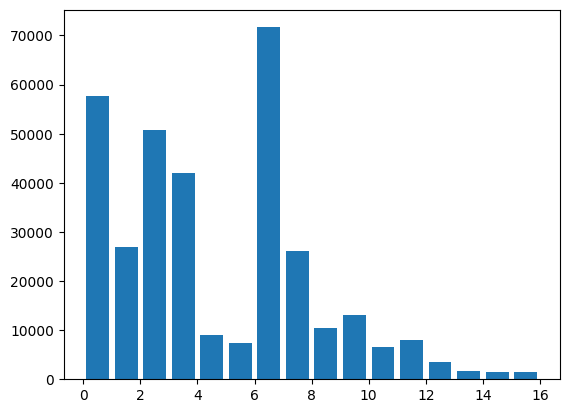

In [170]:
plt.hist(df_train.class_no, bins = list(range(0, 17)), rwidth = 0.8)

In [171]:
from copy import deepcopy

#wycinki ramek danych (kopie głębokie) - jedynie wyczyszczone dane oraz numeryczne oznaczenia klas

print(df_test.columns)

data_test = df_test[["type", "class_no", "post_cleaned"]].copy(deep=True)
data_train = df_train[["type", "class_no", "post_cleaned"]].copy(deep=True)

Index(['index', 'type', 'class_no', 'post', 'post_words', 'post_split',
       'post_flatten', 'post_no_stopwords', 'post_links', 'post_emojis',
       'post_punctuation_flags', 'post_punctuation_cleaned', 'post_numbers',
       'post_no_hashtags', 'post_cleaned'],
      dtype='object')


In [172]:
data_test_bow = data_test
data_train_bow = data_train

In [173]:
#przemieszanie bez seeda, ale w obrębie zbioru treningowego osobno, testowego osobno
data_test_bow = data_test_bow.sample(frac = 1)
data_train_bow = data_train_bow.sample(frac = 1)

In [174]:
data_test_bow['post_joined'] = data_test_bow.apply(lambda x: " ".join(x.post_cleaned), axis=1)
data_train_bow['post_joined'] = data_train_bow.apply(lambda x: " ".join(x.post_cleaned), axis=1)

In [175]:
data_train_bow.head()

,type,class_no,post_cleaned,post_joined
127601,ISTP,9,"[playful, moments, battler, maria, seemed, lik...",playful moments battler maria seemed like estp...
80444,INFJ,0,"[talking, one, prefer, amateur, porn, corporat...",talking one prefer amateur porn corporate made...
163092,INTP,2,"[infj, best, friends, [NUMBER], years, [ELLIPS...",infj best friends [NUMBER] years [ELLIPSIS] co...
259855,INFJ,0,"[get, hold, enfj, friend, [PERIOD], talked, on...",get hold enfj friend [PERIOD] talked one time ...
38210,ENFP,7,"[remember, random, things, well, like, interes...",remember random things well like interested pa...


In [176]:
#Bag of Words

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000)  #max_features niezdefiniowane - cały słownik
X_bow = vectorizer.fit_transform(data_train_bow.post_joined)   #fit & transform
X_bow.shape  #ponad 300 000 postów, 5 000 słów

(338339, 5000)

In [177]:
#TF-IDF

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_bow)
X_tfidf.shape  #ponad 300 000 postów, 5 000 słów

(338339, 5000)

In [178]:
# import tensorflow.keras.utils as ku
Y = data_train_bow.class_no

Logistic Regression

In [179]:
from sklearn.linear_model import LogisticRegression
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(X_tfidf, Y)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [180]:
X_bow_test = vectorizer.transform(data_test_bow.post_joined)   #transform
X_bow_test.shape  #ponad 75 000 postów, 5 000 słów

(84506, 5000)

In [181]:
X_tfidf_test = tfidf_transformer.transform(X_bow_test)         #transform
X_tfidf_test.shape  #ponad 75 000 postów, 5 000 słów

#uwaga, zła kolejność! stratified podział powinien być po preprocessingu

(84506, 5000)

In [182]:
Y_test = data_test_bow.class_no

In [183]:
from sklearn.metrics import accuracy_score

preds = model_log.predict(X_tfidf_test)
accuracy_score(Y_test, preds)

0.2632475800534873

In [184]:
#27% acc bez obcięcia słownika w BoW, tak samo z obcięciem

XGBoost Classifier

In [ ]:
#zła próba, modelxgb nie działa

Linear SVC

In [187]:
from sklearn.svm import LinearSVC

model_linear_svc=LinearSVC(C=0.1)
model_linear_svc.fit(X_tfidf, Y)

c:\Users\marta\anaconda3\envs\mgr\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=0.1)

In [188]:
from sklearn.metrics import accuracy_score

preds = model_linear_svc.predict(X_tfidf_test)
accuracy_score(Y_test, preds)

0.2649634345490261

In [ ]:
#próba bez usuwania ponad 900 wierszy z ilością postów <50 - wyniki bez zmian